# tensorflow keras练习——RNN

In [69]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split

# 使能动态图机制
tf.enable_eager_execution()

## 二进制加法

参考：
[keras 使用RNN实现2进制加法](https://blog.csdn.net/u011311291/article/details/82153819)

### 数据生成

In [70]:
binary_dim = 8 # 二进制数长度
largest_number = pow(2,binary_dim)  
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
int2binary = {i: binary[i] for i in range(largest_number)}

In [71]:
x_train = []
y_train = []
for j in range(1000):
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number / 2)
    b_int = np.random.randint(largest_number / 2)
    c_int = a_int + b_int    #真实和
    print('%d + %d = %d' % (a_int, b_int, c_int))
    
    a = list(int2binary[a_int])
    b = list(int2binary[b_int])
    c = list(int2binary[c_int])
    a.reverse(), b.reverse(), c.reverse()
    print('%s + %s = %s' % (a, b, c))

    tmp_x = np.hstack((np.array([a]).T, np.array([b]).T))
    tmp_y = np.array([c]).T
    #print(tmp_x)
    #print(tmp_y)

    x_train.append(tmp_x)
    y_train.append(tmp_y)

x_train = np.array(x_train)
y_train = np.array(y_train)

125 + 114 = 239
[1, 0, 1, 1, 1, 1, 1, 0] + [0, 1, 0, 0, 1, 1, 1, 0] = [1, 1, 1, 1, 0, 1, 1, 1]
62 + 100 = 162
[0, 1, 1, 1, 1, 1, 0, 0] + [0, 0, 1, 0, 0, 1, 1, 0] = [0, 1, 0, 0, 0, 1, 0, 1]
32 + 85 = 117
[0, 0, 0, 0, 0, 1, 0, 0] + [1, 0, 1, 0, 1, 0, 1, 0] = [1, 0, 1, 0, 1, 1, 1, 0]
122 + 120 = 242
[0, 1, 0, 1, 1, 1, 1, 0] + [0, 0, 0, 1, 1, 1, 1, 0] = [0, 1, 0, 0, 1, 1, 1, 1]
68 + 49 = 117
[0, 0, 1, 0, 0, 0, 1, 0] + [1, 0, 0, 0, 1, 1, 0, 0] = [1, 0, 1, 0, 1, 1, 1, 0]
52 + 54 = 106
[0, 0, 1, 0, 1, 1, 0, 0] + [0, 1, 1, 0, 1, 1, 0, 0] = [0, 1, 0, 1, 0, 1, 1, 0]
36 + 57 = 93
[0, 0, 1, 0, 0, 1, 0, 0] + [1, 0, 0, 1, 1, 1, 0, 0] = [1, 0, 1, 1, 1, 0, 1, 0]
22 + 29 = 51
[0, 1, 1, 0, 1, 0, 0, 0] + [1, 0, 1, 1, 1, 0, 0, 0] = [1, 1, 0, 0, 1, 1, 0, 0]
28 + 36 = 64
[0, 0, 1, 1, 1, 0, 0, 0] + [0, 0, 1, 0, 0, 1, 0, 0] = [0, 0, 0, 0, 0, 0, 1, 0]
53 + 123 = 176
[1, 0, 1, 0, 1, 1, 0, 0] + [1, 1, 0, 1, 1, 1, 1, 0] = [0, 0, 0, 0, 1, 1, 0, 1]
37 + 101 = 138
[1, 0, 1, 0, 0, 1, 0, 0] + [1, 0, 1, 0, 0, 1, 1, 0] 

[0, 0, 1, 1, 0, 0, 0, 0] + [1, 0, 1, 0, 0, 0, 0, 0] = [1, 0, 0, 0, 1, 0, 0, 0]
65 + 93 = 158
[1, 0, 0, 0, 0, 0, 1, 0] + [1, 0, 1, 1, 1, 0, 1, 0] = [0, 1, 1, 1, 1, 0, 0, 1]
97 + 83 = 180
[1, 0, 0, 0, 0, 1, 1, 0] + [1, 1, 0, 0, 1, 0, 1, 0] = [0, 0, 1, 0, 1, 1, 0, 1]
41 + 79 = 120
[1, 0, 0, 1, 0, 1, 0, 0] + [1, 1, 1, 1, 0, 0, 1, 0] = [0, 0, 0, 1, 1, 1, 1, 0]
111 + 94 = 205
[1, 1, 1, 1, 0, 1, 1, 0] + [0, 1, 1, 1, 1, 0, 1, 0] = [1, 0, 1, 1, 0, 0, 1, 1]
41 + 34 = 75
[1, 0, 0, 1, 0, 1, 0, 0] + [0, 1, 0, 0, 0, 1, 0, 0] = [1, 1, 0, 1, 0, 0, 1, 0]
101 + 0 = 101
[1, 0, 1, 0, 0, 1, 1, 0] + [0, 0, 0, 0, 0, 0, 0, 0] = [1, 0, 1, 0, 0, 1, 1, 0]
100 + 8 = 108
[0, 0, 1, 0, 0, 1, 1, 0] + [0, 0, 0, 1, 0, 0, 0, 0] = [0, 0, 1, 1, 0, 1, 1, 0]
6 + 24 = 30
[0, 1, 1, 0, 0, 0, 0, 0] + [0, 0, 0, 1, 1, 0, 0, 0] = [0, 1, 1, 1, 1, 0, 0, 0]
107 + 0 = 107
[1, 1, 0, 1, 0, 1, 1, 0] + [0, 0, 0, 0, 0, 0, 0, 0] = [1, 1, 0, 1, 0, 1, 1, 0]
25 + 126 = 151
[1, 0, 0, 1, 1, 0, 0, 0] + [0, 1, 1, 1, 1, 1, 1, 0] = [1, 1, 1, 0, 1, 0

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)
print(x_train.shape, y_train.shape)
print(x_test.shape, x_test.shape)

(700, 8, 2) (700, 8, 1)
(300, 8, 2) (300, 8, 2)


### 模型构建

![简单RNN结构](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

In [87]:
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, TimeDistributed
from tensorflow.keras.layers import Activation
from tensorflow.keras import Sequential

In [92]:
model = Sequential()
model.add(SimpleRNN(16,
                    input_shape=(8, 2),
                    return_sequences=True,
                    return_state=False,
                    activation='tanh'))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

In [93]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 8, 16)             304       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 8, 1)              17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### 训练

In [94]:
history = model.fit(x_train,
          y_train,
          batch_size=32,
          epochs=200,
          validation_data=(x_test, y_test)) 

Train on 700 samples, validate on 300 samples
Epoch 1/200
700/700 [==============================] - 2s 3ms/sample - loss: 0.7003 - acc: 0.5359 - val_loss: 0.7001 - val_acc: 0.4988
Epoch 2/200
700/700 [==============================] - 0s 138us/sample - loss: 0.6928 - acc: 0.5073 - val_loss: 0.6959 - val_acc: 0.5154
Epoch 3/200
700/700 [==============================] - 0s 139us/sample - loss: 0.6889 - acc: 0.5357 - val_loss: 0.6931 - val_acc: 0.5283
Epoch 4/200
700/700 [==============================] - 0s 139us/sample - loss: 0.6864 - acc: 0.5423 - val_loss: 0.6919 - val_acc: 0.5321
Epoch 5/200
700/700 [==============================] - 0s 138us/sample - loss: 0.6847 - acc: 0.5452 - val_loss: 0.6904 - val_acc: 0.5254
Epoch 6/200
700/700 [==============================] - 0s 140us/sample - loss: 0.6830 - acc: 0.5487 - val_loss: 0.6891 - val_acc: 0.5263
Epoch 7/200
700/700 [==============================] - 0s 139us/sample - loss: 0.6819 - acc: 0.5577 - val_loss: 0.6890 - val_acc: 0.51

700/700 [==============================] - 0s 142us/sample - loss: 0.2702 - acc: 0.9998 - val_loss: 0.2651 - val_acc: 0.9992
Epoch 61/200
700/700 [==============================] - 0s 139us/sample - loss: 0.2553 - acc: 1.0000 - val_loss: 0.2509 - val_acc: 1.0000
Epoch 62/200
700/700 [==============================] - 0s 139us/sample - loss: 0.2415 - acc: 1.0000 - val_loss: 0.2368 - val_acc: 1.0000
Epoch 63/200
700/700 [==============================] - 0s 136us/sample - loss: 0.2282 - acc: 1.0000 - val_loss: 0.2237 - val_acc: 1.0000
Epoch 64/200
700/700 [==============================] - 0s 138us/sample - loss: 0.2159 - acc: 1.0000 - val_loss: 0.2116 - val_acc: 1.0000
Epoch 65/200
700/700 [==============================] - 0s 136us/sample - loss: 0.2042 - acc: 1.0000 - val_loss: 0.2003 - val_acc: 1.0000
Epoch 66/200
700/700 [==============================] - 0s 140us/sample - loss: 0.1934 - acc: 1.0000 - val_loss: 0.1896 - val_acc: 1.0000
Epoch 67/200
700/700 [=========================

700/700 [==============================] - 0s 141us/sample - loss: 0.0289 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 1.0000
Epoch 120/200
700/700 [==============================] - 0s 140us/sample - loss: 0.0283 - acc: 1.0000 - val_loss: 0.0281 - val_acc: 1.0000
Epoch 121/200
700/700 [==============================] - 0s 142us/sample - loss: 0.0276 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 1.0000
Epoch 122/200
700/700 [==============================] - 0s 137us/sample - loss: 0.0269 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 1.0000
Epoch 123/200
700/700 [==============================] - 0s 139us/sample - loss: 0.0263 - acc: 1.0000 - val_loss: 0.0262 - val_acc: 1.0000
Epoch 124/200
700/700 [==============================] - 0s 141us/sample - loss: 0.0257 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 1.0000
Epoch 125/200
700/700 [==============================] - 0s 139us/sample - loss: 0.0251 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 126/200
700/700 [==================

700/700 [==============================] - 0s 138us/sample - loss: 0.0088 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 179/200
700/700 [==============================] - 0s 144us/sample - loss: 0.0087 - acc: 1.0000 - val_loss: 0.0086 - val_acc: 1.0000
Epoch 180/200
700/700 [==============================] - 0s 140us/sample - loss: 0.0085 - acc: 1.0000 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 181/200
700/700 [==============================] - 0s 141us/sample - loss: 0.0084 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 1.0000
Epoch 182/200
700/700 [==============================] - 0s 143us/sample - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 1.0000
Epoch 183/200
700/700 [==============================] - 0s 147us/sample - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 184/200
700/700 [==============================] - 0s 139us/sample - loss: 0.0080 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 185/200
700/700 [==================

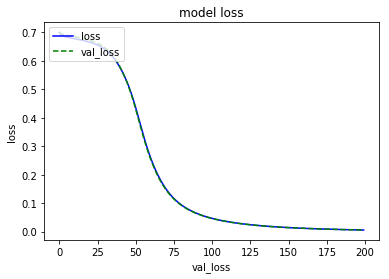

In [95]:
plt.plot(history.history['loss'], c='b')
plt.plot(history.history['val_loss'], linestyle="--", c='g')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("val_loss")
plt.legend(["loss", "val_loss"], loc="upper left")
plt.show()

### 结果评估

In [96]:
score = model.evaluate(x_test, y_test)
print("loss:%.4f" % score[0])
print("acc:%.4f" % score[1])

300/300 [==============================] - 0s 59us/sample - loss: 0.0061 - acc: 1.0000
loss:0.0061
acc:1.0000


In [122]:
a = [1, 1, 0, 1, 0, 0, 1, 0]
b = [1, 0, 0, 0, 1, 1, 0, 0]
predict = model.predict(np.array([a, b]).T.reshape(-1, 8, 2))
predict = predict.flatten()
predict_val = [1 if predict[i] >= 0.5 else 0 for i in range(predict.shape[0])]
print('%s + %s = %s' % (a, b, predict_val))

[1, 1, 0, 1, 0, 0, 1, 0] + [1, 0, 0, 0, 1, 1, 0, 0] = [0, 0, 1, 1, 1, 1, 1, 0]
